<a href="https://colab.research.google.com/github/syedahafsa12/Langgraph_Projects/blob/main/Browsing_AI_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📚 BookBot: Your Book Finder

## 🚀 Overview
BookBot is an AI-powered assistant designed to:
- **Decompose complex queries** into actionable sub-queries.
- **Execute sub-queries in parallel** for efficiency.
- **Synthesize accurate answers** from search results.

It uses Google Custom Search and Gemini AI to deliver top book recommendations quickly.

---

## 💡 Features
1. **Query Decomposition**: Handles multiple queries like `"Top Urdu novels and Top fiction novels"`.
2. **Parallel Processing**: Fetches results for all sub-queries simultaneously.
3. **Precise Recommendations**: Extracts and deduplicates book titles using Gemini AI.


## Demo
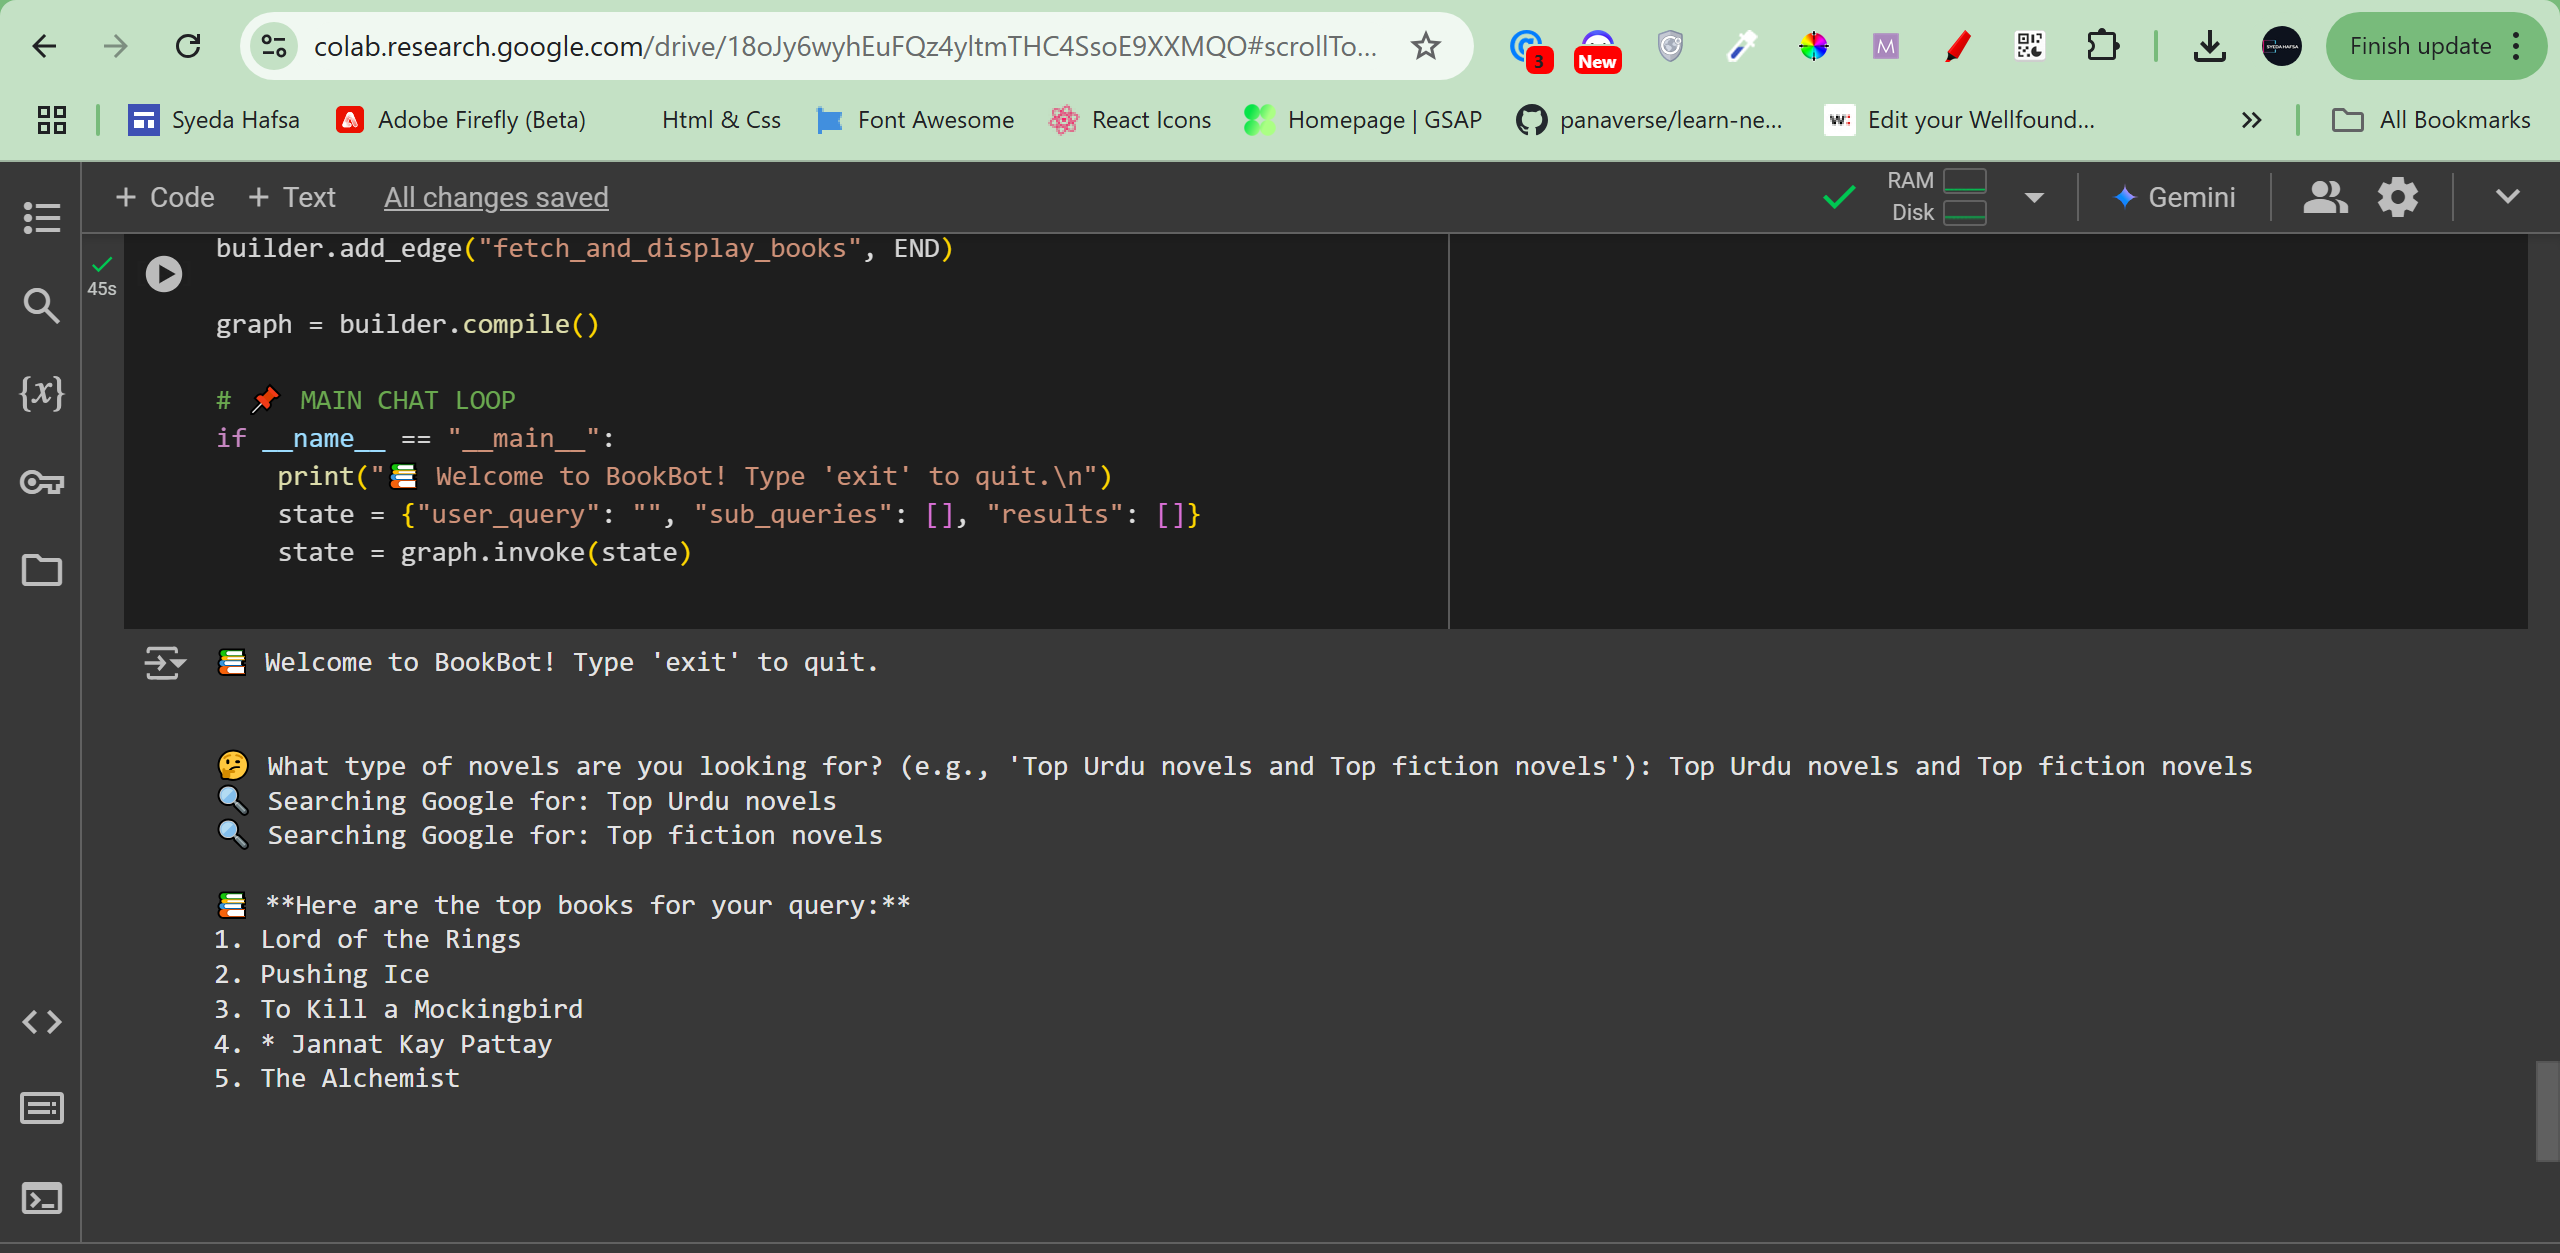

In [ ]:
!pip install langchain_google_genai
!pip install --quiet langgraph langchain-google-genai langchain_core python_dotenv
!pip install langgraph
!pip install google-auth google-auth-oauthlib google-auth-httplib2 google-api-python-client
!pip install langgraph langchain langchain_google_genai langchain_community





   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.25
    Uninstalling langchain-core-0.3.25:
      Successfully uninstalled langchain-core-0.3.25
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.12
    Uninstalling langchain-0.3.12:
      Successfully uninstalled langchain-0.3.12


In [ ]:
# 📌 IMPORTS
from google.colab import userdata  # For API key management
import requests  # To make API calls to Google Custom Search
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from concurrent.futures import ThreadPoolExecutor
from typing import TypedDict

# 📌 API KEYS
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')  # Google API key
SEARCH_ENGINE_ID = userdata.get('SEARCH_ENGINE_ID')  # Google Search Engine ID
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')  # Gemini API key

# Validate API keys
if not GOOGLE_API_KEY or not SEARCH_ENGINE_ID or not GEMINI_API_KEY:
    raise ValueError("❌ Missing API keys. Please set GOOGLE_API_KEY, SEARCH_ENGINE_ID, and GEMINI_API_KEY.")

# Initialize Gemini LLM
llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro", google_api_key=GEMINI_API_KEY)

# 📌 STATE DEFINITION
class BookBotState(TypedDict):
    user_query: str
    sub_queries: list
    results: list

# 📌 HELPER FUNCTIONS
def decompose_query(query: str):
    """Break down the user query into multiple sub-queries."""
    if "and" in query.lower():
        return [sub_query.strip() for sub_query in query.split("and")]
    return [query]

def search_books_with_google(query: str):
    """Search for books using Google Custom Search API."""
    print(f"🔍 Searching Google for: {query}")
    url = f"https://www.googleapis.com/customsearch/v1"
    params = {
        "q": query,
        "cx": SEARCH_ENGINE_ID,
        "key": GOOGLE_API_KEY,
        "num": 5  # Limit to 5 results
    }
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        return response.json().get("items", [])
    except Exception as e:
        print(f"❌ Error searching books on Google: {e}")
        return []

def extract_book_titles_with_gemini(google_results):
    """Extract book titles from Google search results using Gemini."""
    try:
        # Combine Google titles and snippets into raw text
        raw_text = "\n".join(
            [item.get("title", "") + " " + item.get("snippet", "") for item in google_results]
        )
        if not raw_text.strip():  # If Google results are empty
            return []

        # Prompt Gemini to extract only book titles
        prompt = f"""
        From the following text, extract only the names of novels.
        Ignore any articles, links, or general descriptions.
        Text:
        {raw_text}
        """
        response = llm.invoke([{"role": "user", "content": prompt}])
        book_titles = response.content.strip().split("\n")
        return [title.strip() for title in book_titles if title.strip()]
    except Exception as e:
        print(f"❌ Error extracting book titles with Gemini: {e}")
        return []

def fetch_books_in_parallel(sub_queries):
    """Fetch books for multiple sub-queries in parallel."""
    with ThreadPoolExecutor() as executor:
        raw_results = list(executor.map(search_books_with_google, sub_queries))
    return raw_results

def synthesize_results(results):
    """Combine and deduplicate results from multiple sub-queries."""
    all_titles = {title for result in results for title in result}
    return list(all_titles)[:5]  # Ensure no more than 5 titles

# 📌 NODES (CHATBOT STEPS)
def ask_for_query(state: BookBotState):
    """Prompt the user for their query."""
    user_query = input("\n🤔 What type of novels are you looking for? (e.g., 'Top Urdu novels and Top fiction novels'): ").strip()
    state["user_query"] = user_query
    state["sub_queries"] = decompose_query(user_query)
    return state

def fetch_and_display_books(state: BookBotState):
    """Search for books and display plain text results."""
    sub_queries = state["sub_queries"]
    # Search Google in parallel
    raw_results = fetch_books_in_parallel(sub_queries)
    # Extract book titles
    refined_results = [extract_book_titles_with_gemini(results) for results in raw_results]
    # Synthesize results
    state["results"] = synthesize_results(refined_results)
    # Display results
    if state["results"]:
        print("\n📚 **Here are the top books for your query:**")
        for idx, title in enumerate(state["results"], 1):
            print(f"{idx}. {title}")
    else:
        print("❌ No books found for your query. Please try a different search.")
    return state

# 📌 LANGGRAPH DEFINITION
builder = StateGraph(BookBotState)
builder.add_node("ask_for_query", ask_for_query)
builder.add_node("fetch_and_display_books", fetch_and_display_books)

builder.add_edge(START, "ask_for_query")
builder.add_edge("ask_for_query", "fetch_and_display_books")
builder.add_edge("fetch_and_display_books", END)

graph = builder.compile()

# 📌 MAIN CHAT LOOP
if __name__ == "__main__":
    print("📚 Welcome to BookBot! Type 'exit' to quit.\n")
    state = {"user_query": "", "sub_queries": [], "results": []}
    state = graph.invoke(state)


📚 Welcome to BookBot! Type 'exit' to quit.


🤔 What type of novels are you looking for? (e.g., 'Top Urdu novels and Top fiction novels'): Top Urdu novels and Top fiction novels
🔍 Searching Google for: Top Urdu novels
🔍 Searching Google for: Top fiction novels

📚 **Here are the top books for your query:**
1. Lord of the Rings
2. Pushing Ice
3. To Kill a Mockingbird
4. * Jannat Kay Pattay
5. The Alchemist
